# Comparison of two DataGenerator approaches for GLV

**If we get the exact same runs if we apply the patch proposed in https://gitlab.com/mia_jinns/jinns/-/issues/6 to `DataGeneratorODE`.**

**DataGenerators with eqx.Modules are a few seconds faster on this problem**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-07-17 15:51:17.300717: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [6]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [7]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)

Initialize 3 set of neural network parameters for the 3 populations

In [8]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)

Visualize the output of the neural networks before the parameter learning step

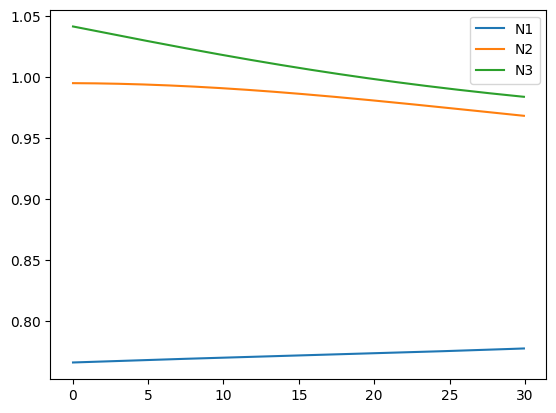

In [9]:
vectorized_u_init = vmap(lambda t: u(t, init_nn_params_list[0]), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_nn_params_list[1]), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_nn_params_list[2]), (0), 0)


plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend()

## Model parameters

In [10]:
# initial conditions for each species
N_0 = jnp.array([10., 7., 4.])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that for the interaction between the species **with itself** is always at position 0
# NOTE minus sign 
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]])

## Loss construction

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [11]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = {
    str(i): init_nn_params_list[i]
    for i in range(3)
}

init_params["eq_params"] = {
    str(i):{
        "carrying_capacity": carrying_capacities[i],
        "growth_rate": growth_rates[i],
        "interactions": interactions[i, :]
    }
    for i in range(3)
}

We construct a SystemLossODE with GeneralizedLotkaVolterra losses for each population. Here `key_main` refer to the key in `params["nn_params"]` which are the parameters for the main PINN of the equation (the PINN which represents the solution differentiated with respect to the `t`). `key_others` refer to the keys in `params["nn_params"]` which are the parameters for the PINNs which interact with `key_main`.

In [12]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="0", keys_other=["1", "2"], Tmax=Tmax)
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="1", keys_other=["0", "2"], Tmax=Tmax)
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="2", keys_other=["0", "1"], Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax}

loss = jinns.loss.SystemLossODE(
    u_dict={"0":u, "1":u, "2":u},
    loss_weights=loss_weights,
    dynamic_loss_dict={"0": N1_dynamic_loss, "1":N2_dynamic_loss, "2":N3_dynamic_loss},
    initial_condition_dict={"0":(float(tmin), N_0[0]), "1":(float(tmin), N_0[1]), "2":(float(tmin), N_0[2])}
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [14]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [15]:
n_iter = int(50000)

In [16]:
key, subkey = random.split(key)

In [17]:
import time
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _ = jinns.solve(
    init_params=init_params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=1
)
total_loss_list.block_until_ready()
end = time.time()
print(f"Compilation time {end - start}")

[train] Iteration 0: loss value = 4579.08984375
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 4579.08984375
Compilation time 6.51482081413269


In [18]:
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _ = jinns.solve(
    init_params=init_params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)
total_loss_list.block_until_ready()
end = time.time()
print(f"Computation time {end - start}")

[train] Iteration 0: loss value = 4579.20751953125
[train] Iteration 1000: loss value = 318.93524169921875
[train] Iteration 2000: loss value = 225.19122314453125
[train] Iteration 3000: loss value = 151.1911163330078
[train] Iteration 4000: loss value = 91.68376159667969
[train] Iteration 5000: loss value = 57.10353469848633
[train] Iteration 6000: loss value = 35.48581314086914
[train] Iteration 7000: loss value = 23.551166534423828
[train] Iteration 8000: loss value = 15.873689651489258
[train] Iteration 9000: loss value = 10.598747253417969
[train] Iteration 10000: loss value = 7.436782360076904
[train] Iteration 11000: loss value = 5.2051520347595215
[train] Iteration 12000: loss value = 3.784611463546753
[train] Iteration 13000: loss value = 2.5023605823516846
[train] Iteration 14000: loss value = 2.0282416343688965
[train] Iteration 15000: loss value = 1.4834702014923096
[train] Iteration 16000: loss value = 0.9966021776199341
[train] Iteration 17000: loss value = 1.163562417030

In [19]:
total_loss_list[-1]

Array(0.06654926, dtype=float32)

## Results

Plot the loss values

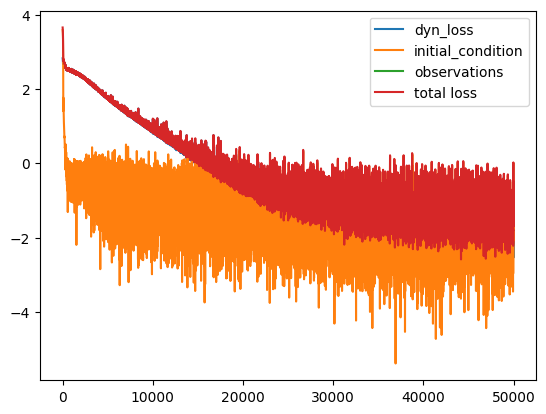

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

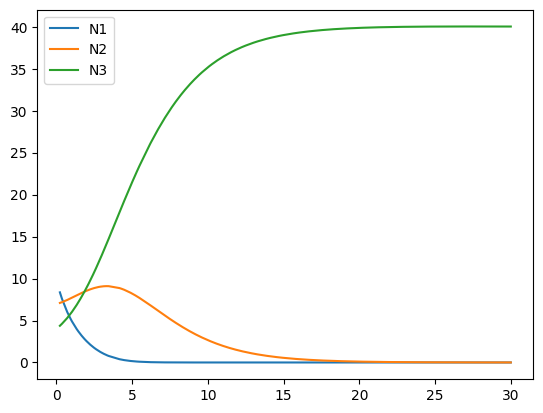

In [21]:
u_est_fp = vmap(lambda t:u(t, params["nn_params"]["0"]), (0), 0)
v_est_fp = vmap(lambda t:u(t, params["nn_params"]["1"]), (0), 0)
w_est_fp = vmap(lambda t:u(t, params["nn_params"]["2"]), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

plt.plot(val_data.times.sort(axis=0) * Tmax, u_est_fp(val_data.times.sort(axis=0)), label="N1")
plt.plot(val_data.times.sort(axis=0) * Tmax, v_est_fp(val_data.times.sort(axis=0)), label="N2")
plt.plot(val_data.times.sort(axis=0) * Tmax, w_est_fp(val_data.times.sort(axis=0)), label="N3")

plt.legend()

## Test with the new DataGenerators which are equinox Modules

In [22]:
key = random.PRNGKey(2)
key, subkey = random.split(key)

In [23]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data_eqx = jinns.data.DataGeneratorODE_eqx(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)
print(jnp.allclose(jnp.sort(train_data_eqx.times), jnp.sort(train_data_eqx.times)))

True


We do not redefine `init_nn_params_list` for the run to be comparable

In [24]:
N1_dynamic_loss_eqx = jinns.loss.GeneralizedLotkaVolterra_eqx(key_main="0", keys_other=["1", "2"], Tmax=Tmax)
N2_dynamic_loss_eqx = jinns.loss.GeneralizedLotkaVolterra_eqx(key_main="1", keys_other=["0", "2"], Tmax=Tmax)
N3_dynamic_loss_eqx = jinns.loss.GeneralizedLotkaVolterra_eqx(key_main="2", keys_other=["0", "1"], Tmax=Tmax)

In [25]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax}

loss_eqx = jinns.loss.SystemLossODE_eqx(
    u_dict={"0":u, "1":u, "2":u},
    loss_weights=loss_weights,
    dynamic_loss_dict={"0": N1_dynamic_loss_eqx, "1":N2_dynamic_loss_eqx, "2":N3_dynamic_loss_eqx},
    initial_condition_dict={"0":(float(tmin), N_0[0]), "1":(float(tmin), N_0[1]), "2":(float(tmin), N_0[2])}
)

In [26]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [27]:
import time
start = time.time()
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _ = jinns.solve(
    init_params=init_params,
    data=train_data_eqx,
    optimizer=tx,
    loss=loss_eqx,
    n_iter=1
)
total_loss_list.block_until_ready()
end = time.time()
print(f"Compilation time {end - start}")

[train] Iteration 0: loss value = 4579.2880859375
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 4579.2880859375
Compilation time 6.255517244338989


In [28]:
start = time.time()
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _ = jinns.solve(
    init_params=init_params,
    data=train_data_eqx,
    optimizer=tx,
    loss=loss_eqx,
    n_iter=n_iter
)
total_loss_list.block_until_ready()
end = time.time()
print(f"Computation time {end - start}")

[train] Iteration 0: loss value = 4579.2880859375
[train] Iteration 1000: loss value = 328.6263427734375
[train] Iteration 2000: loss value = 239.6716766357422
[train] Iteration 3000: loss value = 145.8246612548828
[train] Iteration 4000: loss value = 93.41883087158203
[train] Iteration 5000: loss value = 56.60783386230469
[train] Iteration 6000: loss value = 46.444374084472656
[train] Iteration 7000: loss value = 24.82666778564453
[train] Iteration 8000: loss value = 17.84739112854004
[train] Iteration 9000: loss value = 12.136947631835938
[train] Iteration 10000: loss value = 8.888673782348633
[train] Iteration 11000: loss value = 5.46597957611084
[train] Iteration 12000: loss value = 4.571617603302002
[train] Iteration 13000: loss value = 2.892017126083374
[train] Iteration 14000: loss value = 2.113278865814209
[train] Iteration 15000: loss value = 1.6344051361083984
[train] Iteration 16000: loss value = 1.253731369972229
[train] Iteration 17000: loss value = 1.4090133905410767
[tra

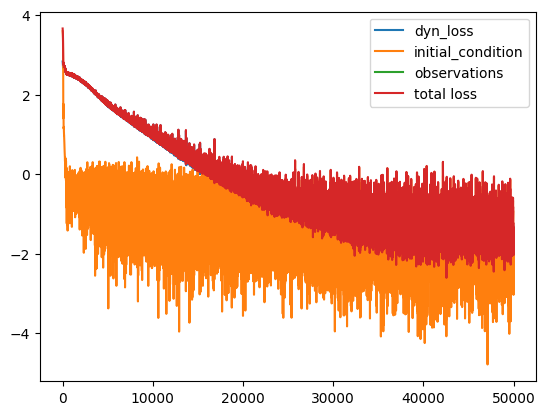

In [29]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

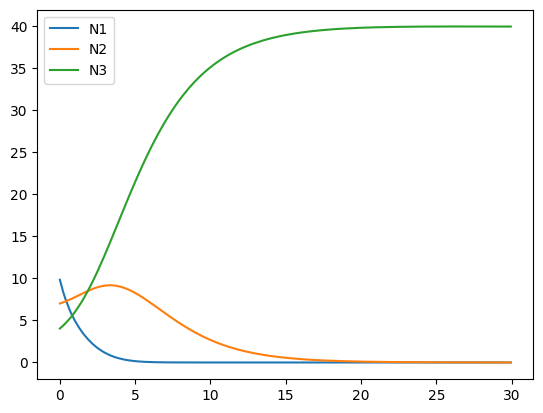

In [30]:
u_est_fp = vmap(lambda t:u(t, params["nn_params"]["0"]), (0), 0)
v_est_fp = vmap(lambda t:u(t, params["nn_params"]["1"]), (0), 0)
w_est_fp = vmap(lambda t:u(t, params["nn_params"]["2"]), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE_eqx(subkey, n, tmin, tmax, batch_size, method)

plt.plot(val_data.times.sort(axis=0) * Tmax, u_est_fp(val_data.times.sort(axis=0)), label="N1")
plt.plot(val_data.times.sort(axis=0) * Tmax, v_est_fp(val_data.times.sort(axis=0)), label="N2")
plt.plot(val_data.times.sort(axis=0) * Tmax, w_est_fp(val_data.times.sort(axis=0)), label="N3")

plt.legend()

## Test DG

In [31]:
key = jax.random.PRNGKey(2)
n = 320
batch_size = 160
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)
print(train_data.curr_time_idx)
_ = train_data.get_batch()
print(train_data.curr_time_idx)
_ = train_data.get_batch()
print(train_data.curr_time_idx)
_ = train_data.get_batch()
print(train_data.curr_time_idx)
_ = train_data.get_batch()
print(train_data.curr_time_idx)

0
160
320
0
160


In [32]:
key = jax.random.PRNGKey(2)
n = 320
batch_size = 160
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE_eqx(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)
print(train_data.curr_time_idx)
train_data, _ = train_data.get_batch()
print(train_data.curr_time_idx)
train_data, _ = train_data.get_batch()
print(train_data.curr_time_idx)
train_data, _ = train_data.get_batch()
print(train_data.curr_time_idx)
train_data, _ = train_data.get_batch()
print(train_data.curr_time_idx)

2147483486
0
160
320
0


In [33]:
jnp.iinfo(jnp.int32).max + 100

2147483747